In [225]:
from PIL import Image
import numpy as np
import os
import skimage.io as io
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import functools
import multiprocessing


train_val_file_path = "/mnt/cube/projects/bsds500/HED-BSDS/train_pair.lst"
train_val_files_root = "/mnt/cube/projects/bsds500/HED-BSDS/"

def get_train_val_ids():
  """Get image ids for train and val."""
  train_ids = tf.gfile.ListDirectory("/home/vveeraba/src/v1net_bsds/data/BSDS500/data/images/train/")
  val_ids = tf.gfile.ListDirectory("/home/vveeraba/src/v1net_bsds/data/BSDS500/data/images/val/")
  train_ids = [i.split(".")[0] for i in train_ids]
  val_ids = [i.split(".")[0] for i in val_ids]
  return train_ids, val_ids

# Helper functions for defining tf types
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def write_image_annotation_pairs_to_tfrecord(filename_pairs, tfrecords_filename):
  """Writes given image/annotation pairs to the tfrecords file.
  The function reads each image/annotation pair given filenames
  of image and respective annotation and writes it to the tfrecord
  file.
  Parameters
  ----------
  filename_pairs : array of tuples (img_filepath, annotation_filepath)
      Array of tuples of image/annotation filenames
  tfrecords_filename : string
      Tfrecords filename to write the image/annotation pairs
  """
  writer = tf.python_io.TFRecordWriter(tfrecords_filename)
  for path_pair in tqdm(filename_pairs):
    img_path, annotation_path = path_pair
    img = np.array(Image.open(os.path.join(train_val_files_root,
                                           img_path)))
    if img.shape[-1] == 1:
      img = np.repeat(img, 3, axis=-1)
    img = img / 255.
    annotation = np.array(Image.open(os.path.join(train_val_files_root,
                                                  annotation_path)))
    if len(annotation.shape) == 3:
      annotation = annotation[:, :, 0]
    annotation = annotation / 255.
    annotation[annotation>=0.25] = 1
    annotation[annotation!=1] = 0
    assert len(annotation.shape) == 2
    assert tuple(annotation.shape) == tuple(img.shape[:-1])

    img, annotation = np.float32(img), np.float32(annotation)

    height = img.shape[0]
    width = img.shape[1]

    img_raw = img.tostring()
    annotation_raw = annotation.tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw),
        'image_path': _bytes_feature(img_path.encode('utf-8'))}))

    writer.write(example.SerializeToString())
  writer.close()


def get_image_annotation_pairs(filename):
  """Load image annotation pairs from file."""
  train_ids, val_ids = get_train_val_ids()
  with tf.gfile.Open(filename, "r") as f:
    img_pairs = f.read().strip().split("\n")
  train_pairs, val_pairs = [], []
  for pair in img_pairs:
    img, gt = pair.split(" ")
    img_id = img.split("/")[-1].split(".")[0]
    if img_id in train_ids:
      train_pairs.append((img, gt))
    else:
      val_pairs.append((img, gt))
  return train_pairs, val_pairs


def write_tfrecords(filename, num_train_shards=100):
  base_tfr_path = "/mnt/cube/projects/bsds500/HED-BSDS/tfrecords"
  train_tfr_filename = "train"
  val_tfr_filename = "validation"
  train_pairs, val_pairs = get_image_annotation_pairs(filename)
  np.random.shuffle(train_pairs)
  np.random.shuffle(val_pairs)
  shard_step = len(train_pairs) // num_train_shards
  for shard_idx in np.arange(0, len(train_pairs), shard_step):
    curr_batch = train_pairs[shard_idx: shard_idx+shard_step]
    curr_idx = shard_idx // shard_step + 1
    curr_tfr_filename = "%s-%s-of-%s" % (train_tfr_filename,
                                         curr_idx,
                                         num_train_shards)
    curr_tfr_filename = os.path.join(base_tfr_path,
                                     curr_tfr_filename)
    print("Writing %s .." % curr_tfr_filename)
    write_image_annotation_pairs_to_tfrecord(curr_batch,
                                             curr_tfr_filename)

In [226]:
write_tfrecords(train_val_file_path)

  0%|          | 0/192 [00:00<?, ?it/s]

Writing /mnt/cube/projects/bsds500/HED-BSDS/tfrecords/train-1-of-100 ..


100%|██████████| 192/192 [00:02<00:00, 80.86it/s]


In [252]:
class BSDSDataProvider:
  """BSDS500 dataset."""
  def __init__(self,
               batch_size,
               is_training,
               data_dir=None,
               ):
    # TODO(vveeraba): Add custom image size
    self.batch_size = batch_size
    threads = multiprocessing.cpu_count()
    # load tfrecord files
    if is_training:
      self.training = True
      glob_pattern = "%s/train*" % data_dir
      self.num_examples = 19200
    else:
      self.training=False
      glob_pattern = "%s/validation*" % data_dir
      self.num_examples = 9600
    files = tf.data.Dataset.list_files(glob_pattern, shuffle=is_training)
    # parallel fetching of tfrecords dataset
    dataset = files.apply(tf.data.experimental.parallel_interleave(
                            self.fetch_dataset, cycle_length=threads, 
                            sloppy=True))
    # shuffling dataset
    dataset = dataset.shuffle(buffer_size=8 * self.batch_size, 
                              seed=None)
    dataset = dataset.repeat(count=None)
    # use decode function to retrieve images and labels
    dataset = dataset.apply(
                tf.data.experimental.map_and_batch(self.decode_feats,
                                                   batch_size=self.batch_size,
                                                   num_parallel_batches=threads,
                                                   drop_remainder=True))
    self.dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  def fetch_dataset(self, filename):
    """Fetch tf.data.Dataset from tfrecord filename."""
    buffer_size = 8 * 1024 * 1024  # 8 MiB per file
    dataset = tf.data.TFRecordDataset(filename, buffer_size=buffer_size)
    return dataset

  def decode_feats(self, tfrecord):
    """Decode features written in tfrecords."""
    feat_dict = {
        "height": tf.FixedLenFeature(
            [1], tf.int64),
        "width": tf.FixedLenFeature(
            [1], tf.int64),
        "image_raw": tf.FixedLenFeature(
            [], tf.string),
        "mask_raw": tf.FixedLenFeature(
            [], tf.string),
        "image_path": tf.FixedLenFeature(
            [], tf.string)
        }
    sample = tf.parse_single_example(tfrecord, feat_dict)
    
    # Deserialize data
    img = tf.decode_raw(sample["image_raw"], tf.float32)
    # img = tf.cast(img, tf.uint8)
    mask = tf.decode_raw(sample["mask_raw"], tf.float32)
    height = sample["height"][0]
    width = sample["width"][0]
    img = tf.reshape(img, (height, width, 3))
    mask = tf.reshape(mask, (height, width, 1))
    img_mask = tf.concat([img, mask], axis=-1)
    img_mask = tf.image.resize_with_crop_or_pad(img_mask, 400, 400)
    img = tf.stack(tf.unstack(img_mask, axis=-1)[:-1], axis=-1)
    mask = tf.unstack(img_mask, axis=-1)[-1]
    return {"image": img}, {"label": mask}


In [253]:
dataprovider = BSDSDataProvider(1, True, "/mnt/cube/projects/bsds500/HED-BSDS/tfrecords")
dataset = dataprovider.dataset
iterator = dataset.make_one_shot_iterator()
img, mask = iterator.get_next()
sess = tf.Session()


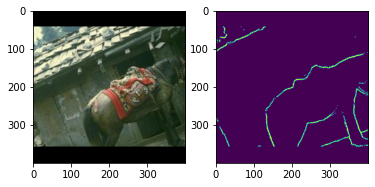

[0. 1.]


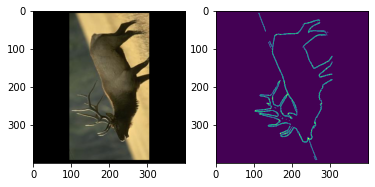

[0. 1.]


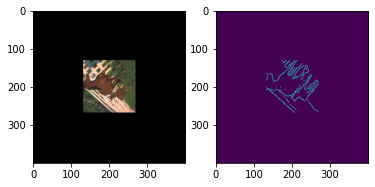

[0. 1.]


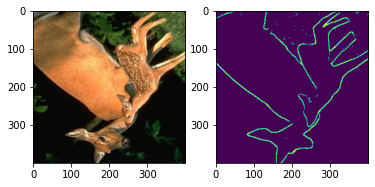

[0. 1.]


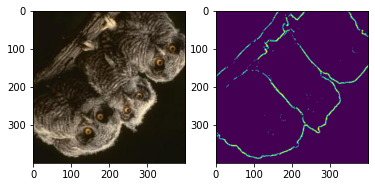

[0. 1.]


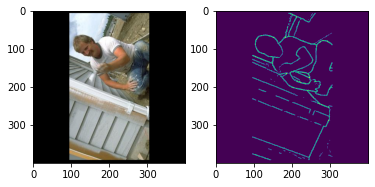

[0. 1.]


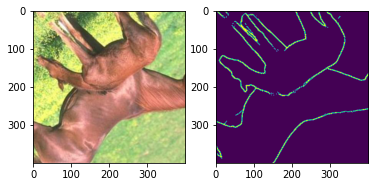

[0. 1.]


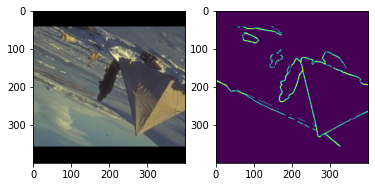

[0. 1.]


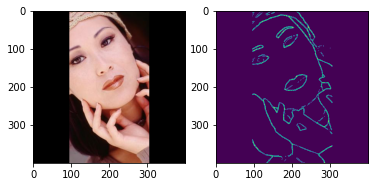

[0. 1.]


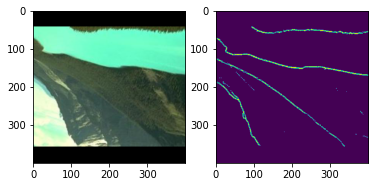

[0. 1.]


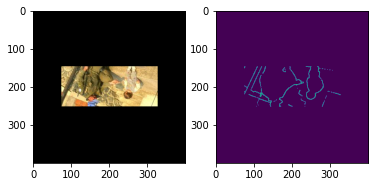

[0. 1.]


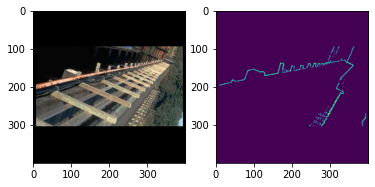

[0. 1.]


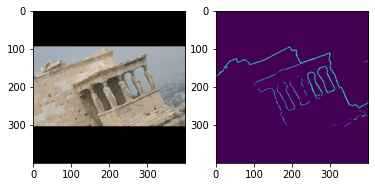

[0. 1.]


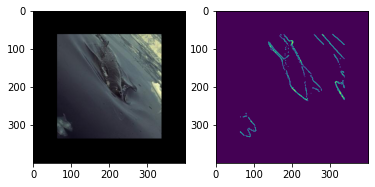

[0. 1.]


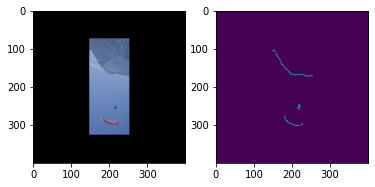

[0. 1.]


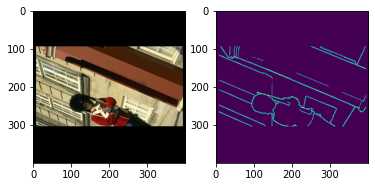

[0. 1.]


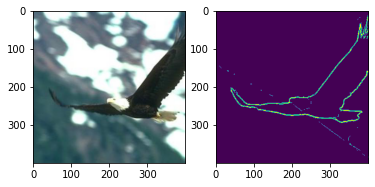

[0. 1.]


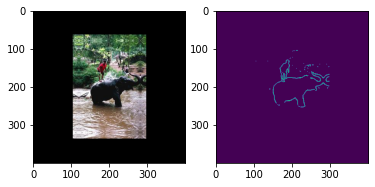

[0. 1.]


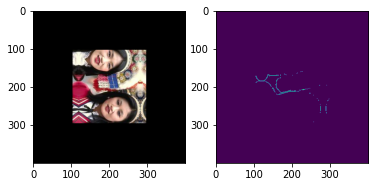

[0. 1.]


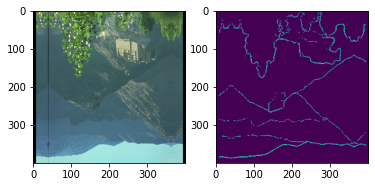

[0. 1.]


In [262]:
for _ in range(20):
  npimg, npmask = sess.run([img["image"], mask["label"]])
  plt.subplot(121); plt.imshow(npimg[0]); plt.subplot(122); plt.imshow(npmask[0])
  plt.show()
  print(np.unique(npmask))


In [240]:
np.unique(npmask)

array([0., 1.], dtype=float32)

In [153]:
x = np.random.uniform(0, 1, (100, 100))

In [155]:
x.min(), x.max()


(6.121473048403825e-05, 0.9999953192236116)

In [159]:
x[x>=0.5] = 1
x[x!=1] = 0

In [160]:
x.min()

0.0

In [161]:
np.unique(x)

array([0., 1.])